In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

from datetime import date, timedelta
import glob
import os

import dask

import matplotlib.pyplot as plt

## Dask cluster

In [6]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="pches",
    # account="open",
    cores=1,
    memory="4GB",
    walltime="00:20:00",
)

cluster.scale(jobs=10)

In [7]:
# print(cluster.job_script())

In [8]:
from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.0.174:34623,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Preliminaries

In [2]:
# Directories
nldas_path = "/storage/group/pches/default/public/NLDAS"
smap_path = "/storage/group/pches/default/public/SMAP"
log_path = "/storage/home/dcl5300/work/current_projects/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/logs"
project_data_path = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA'

# SMAP daily averages

In [17]:
def calculate_daily_avg(date, in_path, out_path, log_path):
    def _preprocess(ds):
        # Add datetime
        dt_all = ds.encoding["source"][63:78]
        datetime = pd.to_datetime(f"{dt_all[:4]}-{dt_all[4:6]}-{dt_all[6:8]} {dt_all[9:11]}:30", format="%Y-%m-%d %H:%M")
        ds = ds.expand_dims(time=[datetime])
        # Select band data
        ds = ds.isel(band=0)
        # Rename coords
        ds = ds.rename({'x':'lon', 'y':'lat'})
        # Rename var
        var_list = ds.encoding["source"].split('_sm_')[1].split('_')
        
        if len(var_list) == 2:
            var_name = f'sm_{var_list[0]}'
        elif len(var_list) == 3:
            var_name = f'sm_{var_list[0]}_{var_list[1]}'

        ds = ds.rename({'band_data':var_name})
        
        # Drop unwanted vards
        ds = ds.drop_vars(['band','spatial_ref'])
        # Return
        return ds

    # Remove dashes
    date_strf = date.strftime("%Y-%m-%d").replace('-','')
    
    # Check if done
    if os.path.isfile(f"{out_path}/SMAP_L4_SM_gph_all_{date_strf}.nc"):
        return None
        
    # Read entire day (check if complete)
    files = glob.glob(f'{in_path}/SMAP_L4_SM_gph_{date_strf}*.tif')
    if len(files) != 8*4:
        with open(f'{log_path}/SMAP_L4_SM_gph_{date_strf}.txt', 'w') as f:
            f.write(f'Only {len(files)} files')
            return None
    
    # Auto-combine
    ds = xr.combine_by_coords([_preprocess(xr.open_dataset(file)) for file in files])

    # Resample to daily means
    ds_out = ds.resample(time='1D').mean()

    # Store 
    ds_out.to_netcdf(f"{out_path}/SMAP_L4_SM_gph_all_{date_strf}.nc")

In [19]:
%%time
# Define dates
start_date = date(2016, 1, 1)
# end_date = date(2016, 12, 31)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(dask.delayed(calculate_daily_avg)(date=start_date,
                                                     in_path=f'{smap_path}/raw_nc',
                                                     out_path=f'{smap_path}/processed',
                                                     log_path=log_path))
    start_date += delta

# Compute
_ = dask.compute(*delayed)

CPU times: user 10.7 s, sys: 551 ms, total: 11.2 s
Wall time: 53.5 s


### Re-grid to NLDAS grid

In [6]:
# Get NLDAS grid
nldas_grid = xr.open_dataset(f'{nldas_path}/forcing/daily/NLDAS_FORA0125_H.A20221231.nc') # random date

nldas_lon_grid = nldas_grid.lon.to_numpy()
nldas_lat_grid = nldas_grid.lat.to_numpy()

In [7]:
def regrid_to_nldas(date, nldas_lon_grid, nldas_lat_grid, in_path, out_path):
    # Remove dashes
    date_strf = date.strftime("%Y-%m-%d").replace('-','')
    
    # Check if done
    if os.path.isfile(f"{out_path}/SMAP_L4_SM_gph_all_nldas_{date_strf}.nc"):
        return None
        
    # Read
    dr_in = xr.open_dataset(f"{in_path}/SMAP_L4_SM_gph_all_{date_strf}.nc")
    dr_in = dr_in.sortby('lat').sel(lat=slice(20,60), lon=slice(-130,-60)) # generous North America slice
    
    # Regrid conservatively
    ds_out = xr.Dataset(
        {
        "lat": (["lat"], nldas_lat_grid, {"standard_name": "latitude", "units": "degrees_north"}),
        "lon": (["lon"], nldas_lon_grid, {"standard_name": "longitude", "units": "degrees_east"}),
        }
    )
    regridder = xe.Regridder(dr_in, ds_out, 'conservative')
    dr_out = regridder(dr_in)

    # Store 
    dr_out.to_netcdf(f"{out_path}/SMAP_L4_SM_gph_all_nldas_{date_strf}.nc")

In [8]:
%%time
# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(dask.delayed(regrid_to_nldas)(date=start_date,
                                                 nldas_lon_grid=nldas_lon_grid,
                                                 nldas_lat_grid=nldas_lat_grid,
                                                 in_path=f'{smap_path}/processed',
                                                 out_path=f'{smap_path}/processed_nldas_grid'))
    start_date += delta

# Compute
_ = dask.compute(*delayed)

CPU times: user 1min 28s, sys: 6.07 s, total: 1min 34s
Wall time: 9min 36s


### Plot

In [6]:
ds = xr.open_mfdataset('/storage/group/pches/default/public/SMAP/processed_nldas_grid/SMAP_L4_SM_gph_all_*.nc')

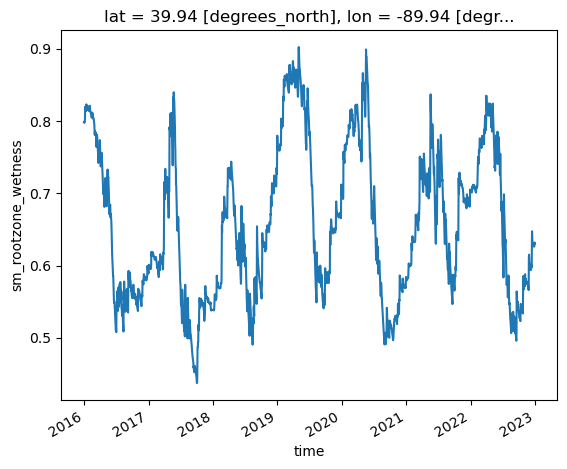

In [7]:
ds.sel(lat=40, lon=-90, method='nearest').sm_rootzone_wetness.plot()

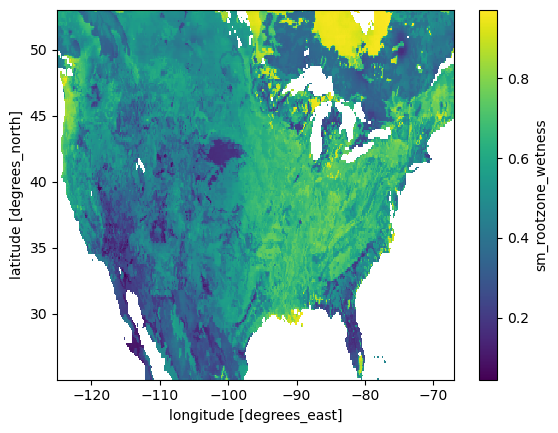

In [8]:
ds.sm_rootzone_wetness.mean(dim='time').plot()

# NLDAS daily averages

### Function definition

In [6]:
def calculate_nldas_daily_avg(date, model, nldas_path, out_path, log_path):

    # Remove dashes
    date_strf = date.strftime("%Y-%m-%d").replace('-','')
    
    # Check if done
    if os.path.isfile(f"{out_path}/NLDAS_{model}0125_H.A{date_strf}.nc"):
        return None
        
    # Read entire day (check if complete)
    files = glob.glob(f'{nldas_path}/NLDAS_{model}0125_H.A{date_strf}*')
    if len(files) != 24:
        with open(f'{log_path}/NLDAS_{model}0125_H_{date_strf}.txt', 'w') as f:
            f.write(f'Only {len(files)} files')
            return None
    
    # Auto-combine
    ds = xr.concat([xr.open_dataset(file) for file in files], dim='time')

    # Resample to daily
    if model == 'FORA':
        ds_apcp = xr.Dataset({'APCP': ds['APCP'].resample(time='1D').sum()})
        ds_tmp = xr.Dataset({'TMP': ds['TMP'].resample(time='1D').mean()}).isel(height=0).drop('height')

        # Merge
        ds_out = xr.merge([ds_apcp, ds_tmp])
    else:
        ds_out = ds.resample(time='1D').mean()

    # Store 
    ds_out.to_netcdf(f"{out_path}/NLDAS_{model}0125_H.A{date_strf}.nc")

## Meteorological forcing

In [9]:
%%time
# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(dask.delayed(calculate_nldas_daily_avg)(date=start_date,
                                                           model = 'FORA',
                                                           nldas_path=f'{nldas_path}/forcing/hourly',
                                                           out_path=f'{nldas_path}/forcing/daily/',
                                                           log_path=log_path))
    start_date += delta

# Compute
_ = dask.compute(*delayed)

CPU times: user 6.5 s, sys: 433 ms, total: 6.93 s
Wall time: 31.6 s


## Soil moisture model outputs

### Calculation

In [7]:
%%time
model = 'NOAH'

# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(dask.delayed(calculate_nldas_daily_avg)(date=start_date,
                                                           model = model,
                                                           nldas_path=f'{nldas_path}/{model}/hourly',
                                                           out_path=f'{nldas_path}/{model}/daily/',
                                                           log_path=log_path))
    start_date += delta

# Compute
_ = dask.compute(*delayed)

CPU times: user 4.51 s, sys: 273 ms, total: 4.78 s
Wall time: 39.1 s


In [8]:
%%time
model = 'MOS'

# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(dask.delayed(calculate_nldas_daily_avg)(date=start_date,
                                                           model = model,
                                                           nldas_path=f'{nldas_path}/{model}AIC/hourly',
                                                           out_path=f'{nldas_path}/{model}AIC/daily/',
                                                           log_path=log_path))
    start_date += delta

# Compute
_ = dask.compute(*delayed)

CPU times: user 3.97 s, sys: 252 ms, total: 4.22 s
Wall time: 14.4 s


In [8]:
%%time
model = 'VIC'

# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(dask.delayed(calculate_nldas_daily_avg)(date=start_date,
                                                           model = model,
                                                           nldas_path=f'{nldas_path}/{model}/hourly',
                                                           out_path=f'{nldas_path}/{model}/daily/',
                                                           log_path=log_path))
    start_date += delta

# Compute
_ = dask.compute(*delayed)

CPU times: user 9.12 s, sys: 588 ms, total: 9.71 s
Wall time: 1min 11s


### Plots

In [ ]:
nldas_dict = {'VIC':'SOILM0_100cm', 'NOAH':'SOILM', 'MOSAIC':'SOILM'}

In [ ]:
ds_vic = xr.open_mfdataset(f'{nldas_path}/VIC/daily/*A20*.nc')
ds_noah = xr.open_mfdataset(f'{nldas_path}/NOAH/daily/*A20*.nc')
ds_mosaic = xr.open_mfdataset(f'{nldas_path}/MOSAIC/daily/*A20*.nc')

In [15]:
# Compute correlations
noah_vic_corr = xr.corr(ds_noah['SOILM'].isel(depth=1), ds_vic['SOILM0_100cm'].isel(depth=0),
                        dim='time').compute()

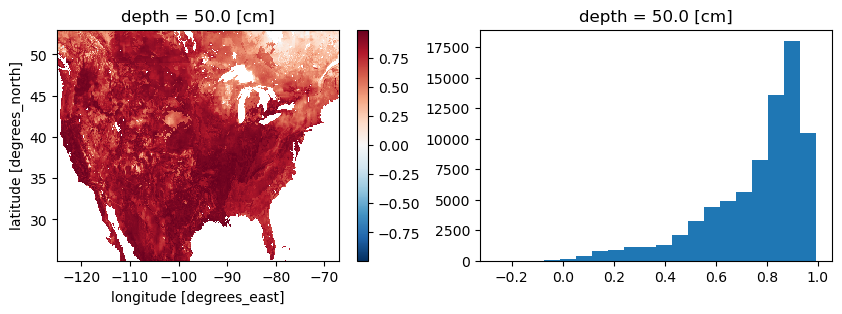

In [23]:
fig, axs = plt.subplots(1,2, figsize=(10,3))

noah_vic_corr.plot(ax=axs[0])
noah_vic_corr.plot.hist(bins=20, ax=axs[1])

plt.show()

In [31]:
# Compute rmse
noah_vic_mse = ((ds_noah['SOILM'].isel(depth=1) - ds_vic['SOILM0_100cm'].isel(depth=0))**2).mean(dim='time').compute()

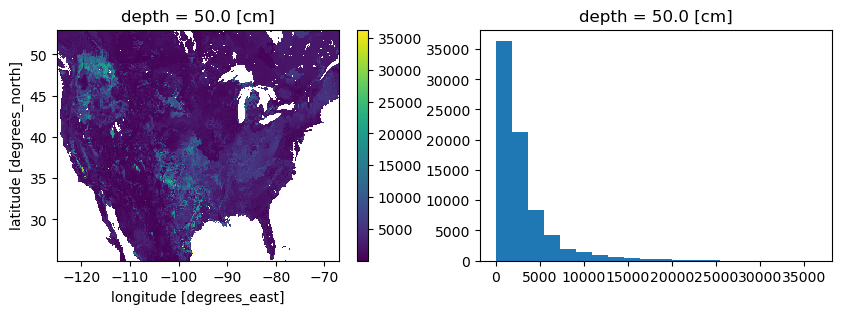

In [32]:
fig, axs = plt.subplots(1,2, figsize=(10,3))

noah_vic_mse.plot(ax=axs[0])
noah_vic_mse.plot.hist(bins=20, ax=axs[1])

plt.show()

In [24]:
# Weekly anomalies
def get_weekly_anomaly(ds):
    ds_tmp = ds.copy()
    ds_tmp = ds_tmp.assign_coords(week=ds_tmp.time.dt.strftime("%W"))
    return (ds_tmp.groupby('week') - ds_tmp.groupby("week").mean("time"))

In [35]:
noah_vic_corr_anom

<xarray.DataArray (lat: 224, lon: 464)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.68780887, 0.69009698, 0.59782292, ..., 0.55415704, 0.59846817,
        0.62901749],
       [0.59815523, 0.6109203 , 0.60603985, ..., 0.54876877, 0.57920329,
        0.62572196],
       [0.50986057, 0.56710833, 0.58209871, ..., 0.55853593, 0.5660808 ,
        0.61398366]])
Coordinates:
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94

In [25]:
# Compute correlations among anomalies
noah_vic_corr_anom = xr.corr(get_weekly_anomaly(ds_noah['SOILM'].isel(depth=1)),
                             get_weekly_anomaly(ds_vic['SOILM0_100cm'].isel(depth=0)),
                             dim='time').compute()

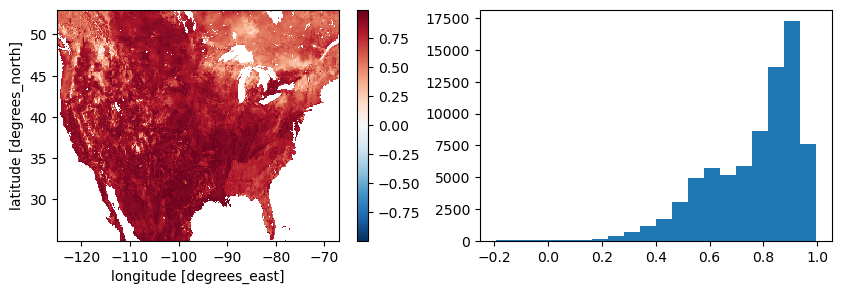

In [26]:
fig, axs = plt.subplots(1,2, figsize=(10,3))

noah_vic_corr_anom.plot(ax=axs[0])
noah_vic_corr_anom.plot.hist(bins=20, ax=axs[1])

plt.show()

In [33]:
# Compute rmse
noah_vic_mse_anom = ((get_weekly_anomaly(ds_noah['SOILM'].isel(depth=1)) - get_weekly_anomaly(ds_vic['SOILM0_100cm'].isel(depth=0)))**2).mean(dim='time').compute()

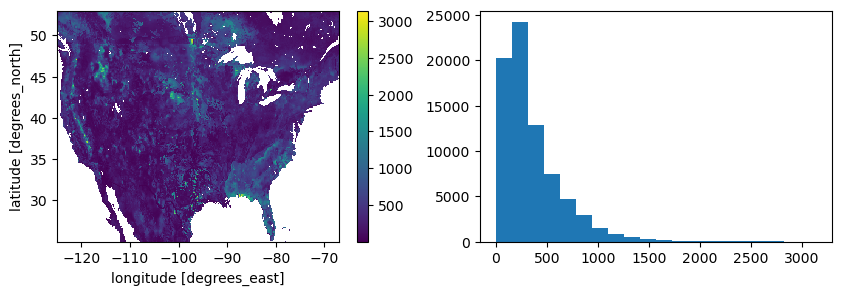

In [34]:
fig, axs = plt.subplots(1,2, figsize=(10,3))

noah_vic_mse_anom.plot(ax=axs[0])
noah_vic_mse_anom.plot.hist(bins=20, ax=axs[1])

plt.show()

In [ ]:
ds_vic_test_loc1 = ds_vic.sel(lat=lat, lon=lon, method='nearest').SOILM0_100cm.load()
ds_noah_test_loc1 = ds_noah.sel(lat=lat, lon=lon, method='nearest').SOILM.load()
ds_mosaic_test_loc1 = ds_mosaic.sel(lat=lat, lon=lon, method='nearest').SOILM.load()
ds_smap_test_loc1 = (ds_smap.sel(lat=lat, lon=lon, method='nearest').sm_rootzone * 1000).load()

In [35]:
# Test location

######### 1
lat=40
lon=-90

ds_vic_test_loc1 = ds_vic.sel(lat=lat, lon=lon, method='nearest').SOILM0_100cm.load()
ds_noah_test_loc1 = ds_noah.sel(lat=lat, lon=lon, method='nearest').SOILM.load()
ds_mosaic_test_loc1 = ds_mosaic.sel(lat=lat, lon=lon, method='nearest').SOILM.load()
ds_smap_test_loc1 = (ds_smap.sel(lat=lat, lon=lon, method='nearest').sm_rootzone * 1000).load()

######### 2
lat=44
lon=-90

ds_vic_test_loc2 = ds_vic.sel(lat=lat, lon=lon, method='nearest').SOILM0_100cm.load()
ds_noah_test_loc2 = ds_noah.sel(lat=lat, lon=lon, method='nearest').SOILM.load()
ds_mosaic_test_loc2 = ds_mosaic.sel(lat=lat, lon=lon, method='nearest').SOILM.load()
ds_smap_test_loc2 = (ds_smap.sel(lat=lat, lon=lon, method='nearest').sm_rootzone * 1000).load()

In [36]:
# Select correct depths for 0-100cm (check depth_bnds for this)
ds_mosaic_test_loc1_rz = ds_mosaic_test_loc1.isel(depth=1)
ds_mosaic_test_loc2_rz = ds_mosaic_test_loc2.isel(depth=1)

ds_noah_test_loc1_rz = ds_noah_test_loc1.isel(depth=1)
ds_noah_test_loc2_rz = ds_noah_test_loc2.isel(depth=1)

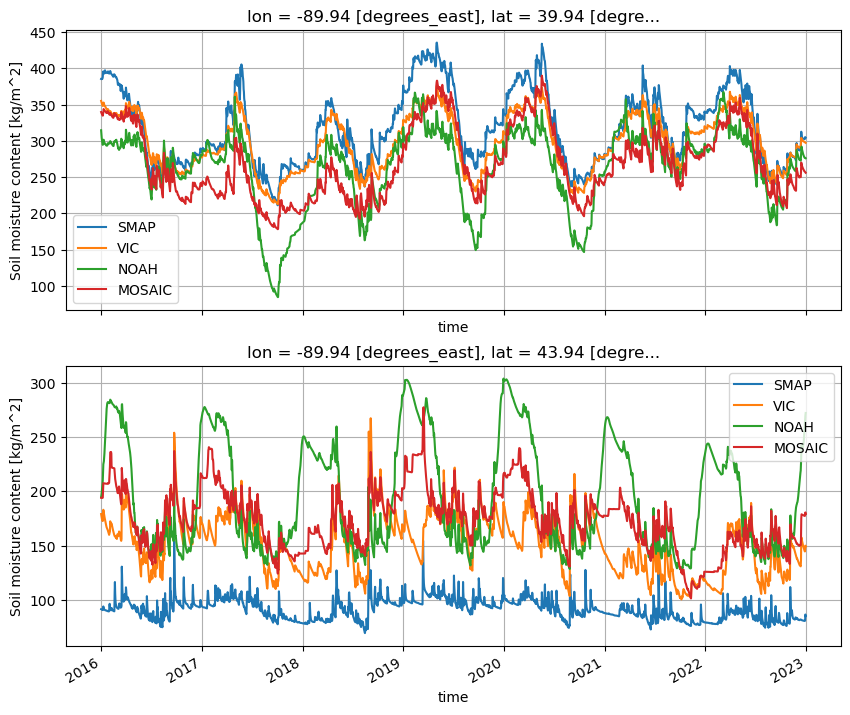

In [37]:
# Plot
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

# Locaion 1
ds_smap_test_loc1.plot(ax=axs[0], label='SMAP')
ds_vic_test_loc1.plot(ax=axs[0], label='VIC')
ds_noah_test_loc1_rz.plot(ax=axs[0], label='NOAH')
ds_mosaic_test_loc1_rz.plot(ax=axs[0], label='MOSAIC')
axs[0].grid()
axs[0].legend()

# Locaion 2
ds_smap_test_loc2.plot(ax=axs[1], label='SMAP')
ds_vic_test_loc2.plot(ax=axs[1], label='VIC')
ds_noah_test_loc2_rz.plot(ax=axs[1], label='NOAH')
ds_mosaic_test_loc2_rz.plot(ax=axs[1], label='MOSAIC')
axs[1].grid()
axs[1].legend()

plt.show()

In [38]:
# Weekly anomalies
def get_weekly_anomaly(ds):
    ds_tmp = ds.copy()
    ds_tmp = ds_tmp.assign_coords(week=ds_tmp.time.dt.strftime("%W"))
    return (ds_tmp.groupby('week') - ds_tmp.groupby("week").mean("time"))

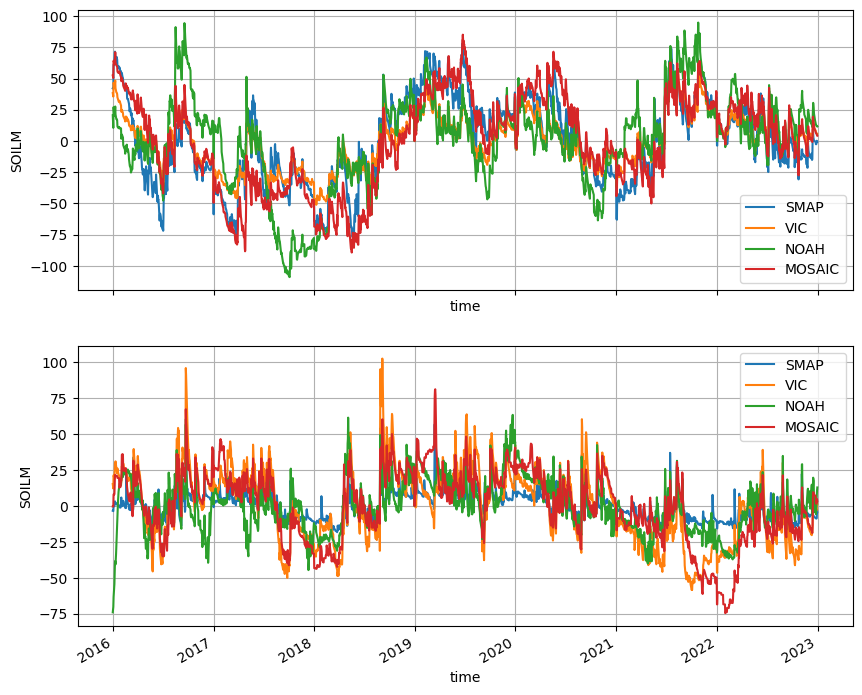

In [40]:
# Plot
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

# Locaion 1
get_weekly_anomaly(ds_smap_test_loc1).plot(ax=axs[0], label='SMAP')
get_weekly_anomaly(ds_vic_test_loc1).plot(ax=axs[0], label='VIC')
get_weekly_anomaly(ds_noah_test_loc1_rz).plot(ax=axs[0], label='NOAH')
get_weekly_anomaly(ds_mosaic_test_loc1_rz).plot(ax=axs[0], label='MOSAIC')
axs[0].grid()
axs[0].legend()

# Locaion 2
get_weekly_anomaly(ds_smap_test_loc2).plot(ax=axs[1], label='SMAP')
get_weekly_anomaly(ds_vic_test_loc2).plot(ax=axs[1], label='VIC')
get_weekly_anomaly(ds_noah_test_loc2_rz).plot(ax=axs[1], label='NOAH')
get_weekly_anomaly(ds_mosaic_test_loc2_rz).plot(ax=axs[1], label='MOSAIC')
axs[1].grid()
axs[1].legend()

plt.show()

In [41]:
# Rolling (window*2)-day anomalies
def get_rolling_anomaly(ds, window=10):
    ds_tmp = ds.copy()

    # Calculate climatology
    ds_clima = []

    for doy in range(1,366):
        doys = [365+doy if doy <= 0 else doy for doy in np.arange(doy-window, doy+window+1)]
        tmp = ds.where(ds.time.dt.dayofyear.isin(doys)).mean(dim='time')
        ds_clima.append(tmp.assign_coords(doy=doy))

    ds_clima = xr.concat(ds_clima, dim='doy')

    # Remove clima
    ds_tmp = ds_tmp.assign_coords(doy = ds_tmp.time.dt.dayofyear)
    return ds_tmp.groupby('doy') - ds_clima

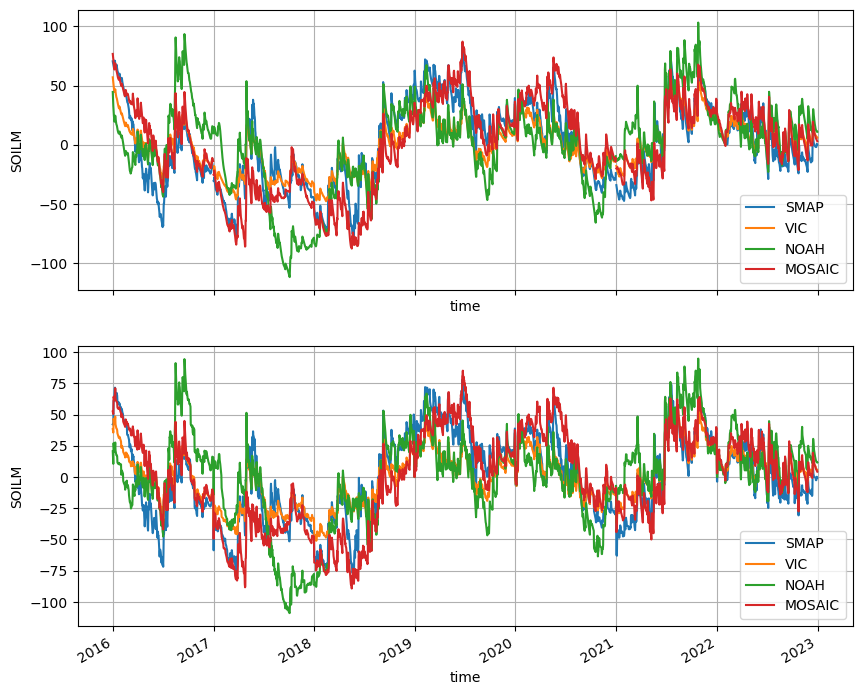

In [42]:
# Plot
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

# Locaion 1
get_rolling_anomaly(ds_smap_test_loc1).plot(ax=axs[0], label='SMAP')
get_rolling_anomaly(ds_vic_test_loc1).plot(ax=axs[0], label='VIC')
get_rolling_anomaly(ds_noah_test_loc1_rz).plot(ax=axs[0], label='NOAH')
get_rolling_anomaly(ds_mosaic_test_loc1_rz).plot(ax=axs[0], label='MOSAIC')
axs[0].grid()
axs[0].legend()

# # Locaion 2
# get_rolling_anomaly(ds_smap_test_loc2).plot(ax=axs[1], label='SMAP')
# get_rolling_anomaly(ds_vic_test_loc2).plot(ax=axs[1], label='VIC')
# get_rolling_anomaly(ds_noah_test_loc2_rz).plot(ax=axs[1], label='NOAH')
# get_rolling_anomaly(ds_mosaic_test_loc2_rz).plot(ax=axs[1], label='MOSAIC')

# Locaion 2
get_weekly_anomaly(ds_smap_test_loc1).plot(ax=axs[1], label='SMAP')
get_weekly_anomaly(ds_vic_test_loc1).plot(ax=axs[1], label='VIC')
get_weekly_anomaly(ds_noah_test_loc1_rz).plot(ax=axs[1], label='NOAH')
get_weekly_anomaly(ds_mosaic_test_loc1_rz).plot(ax=axs[1], label='MOSAIC')
axs[1].grid()
axs[1].legend()

plt.show()

In [43]:
# Weekly standardized anomalies
def get_weekly_stnd_anomaly(ds):
    ds_tmp = ds.copy()
    ds_tmp = ds_tmp.assign_coords(week=ds_tmp.time.dt.strftime("%W"))
    return (ds_tmp.groupby('week') - ds_tmp.groupby("week").mean("time")).groupby("week") / ds_tmp.groupby("week").std("time")

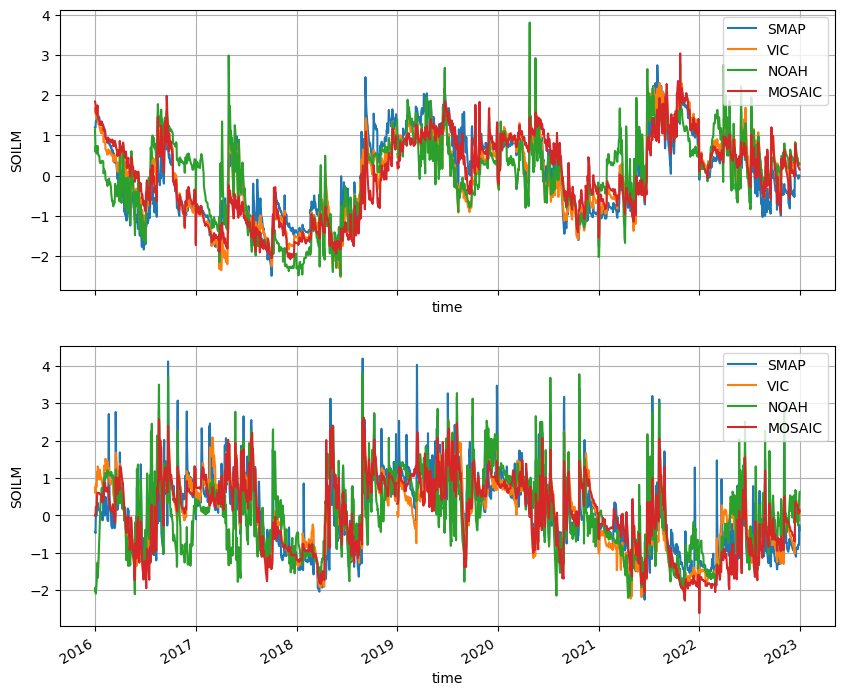

In [44]:
# Plot
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

# Locaion 1
get_weekly_stnd_anomaly(ds_smap_test_loc1).plot(ax=axs[0], label='SMAP')
get_weekly_stnd_anomaly(ds_vic_test_loc1).plot(ax=axs[0], label='VIC')
get_weekly_stnd_anomaly(ds_noah_test_loc1_rz).plot(ax=axs[0], label='NOAH')
get_weekly_stnd_anomaly(ds_mosaic_test_loc1_rz).plot(ax=axs[0], label='MOSAIC')
axs[0].grid()
axs[0].legend()

# Locaion 2
get_weekly_stnd_anomaly(ds_smap_test_loc2).plot(ax=axs[1], label='SMAP')
get_weekly_stnd_anomaly(ds_vic_test_loc2).plot(ax=axs[1], label='VIC')
get_weekly_stnd_anomaly(ds_noah_test_loc2_rz).plot(ax=axs[1], label='NOAH')
get_weekly_stnd_anomaly(ds_mosaic_test_loc2_rz).plot(ax=axs[1], label='MOSAIC')
axs[1].grid()
axs[1].legend()

plt.show()

# Soil information

## Content fractions

In [5]:
# Read soil clay, sand, silt, fractions
ds_soilfrac = xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/GLDASp4_soilfraction_025d.nc4')

In [13]:
# Get NLDAS grid
nldas_grid = xr.open_dataset(f'{nldas_path}/forcing/daily/NLDAS_FORA0125_H.A20221231.nc') # random date

nldas_lon_grid = nldas_grid.lon.to_numpy()
nldas_lat_grid = nldas_grid.lat.to_numpy()

# Regrid conservatively
ds_out = xr.Dataset(
    {
        "lat": (["lat"], nldas_lat_grid, {"standard_name": "latitude", "units": "degrees_north"}),
        "lon": (["lon"], nldas_lon_grid, {"standard_name": "longitude", "units": "degrees_east"}),
    }
)

regridder = xe.Regridder(ds_soilfrac, ds_out, 'conservative')
ds_soilfrac_out = regridder(ds_soilfrac)

# Drop time
ds_soilfrac_out = ds_soilfrac_out.isel(time=0).drop('time')

# Store 
ds_soilfrac_out.to_netcdf(f"{project_data_path}/WBM/geo_inputs/soilfrac_NLDASgrid.nc")

## Available water capacity & wilting point

In [29]:
# Read NOAH soil properties
ds_noah = xr.open_dataset(f'{nldas_path}/NOAH/input/NLDAS_soil_Noah.nc4')

In [32]:
# Calculate awCap in mm/m
awCap = (1000 * (ds_noah['Noah_fieldcap'] - ds_noah['Noah_wiltingp'])).isel(time=0).drop('time')
ds_awCap = xr.Dataset({'awCap':awCap})

ds_awCap.awCap.attrs['units'] = 'mm/m'
ds_awCap.awCap.attrs['note'] = 'Calculated as NOAH field capacity minus wilting point'

# Store
ds_awCap.to_netcdf(f'{project_data_path}/WBM/geo_inputs/NLDAS_NOAH_awCap.nc')

In [39]:
# Wilting point as fraction of awCap
wp = ds_noah['Noah_wiltingp'].isel(time=0).drop('time')
ds_wp = xr.Dataset({'wiltingp':1000 * wp / awCap})

ds_wp.wiltingp.attrs['units'] = 'fraction of awCap'
ds_wp.wiltingp.attrs['note'] = 'Calculated from NOAH'

# Store
ds_wp.to_netcdf(f'{project_data_path}/WBM/geo_inputs/NLDAS_NOAH_wiltingp.nc')

# Leaf Area Index

In [4]:
# GLDAS LAI based on AVHRR satellite, 20-year climatology from 1982 - 2001
# See: https://ldas.gsfc.nasa.gov/gldas/lai-greenness
ds_lai = xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/GLDASp5_CLSM_lai_025d.nc4', decode_times=False)

In [7]:
# Fix time coordinate
ds_lai['time'] = pd.date_range("2000-01-01", periods=12, freq='MS')

# Interpolatet to daily
ds_lai = ds_lai.interp(time=pd.date_range("2000-01-01", periods=366, freq='D'))

In [13]:
# Get NLDAS grid
nldas_grid = xr.open_dataset(f'{nldas_path}/forcing/daily/NLDAS_FORA0125_H.A20221231.nc') # random date

nldas_lon_grid = nldas_grid.lon.to_numpy()
nldas_lat_grid = nldas_grid.lat.to_numpy()

# Regrid conservatively
ds_out = xr.Dataset(
    {
        "lat": (["lat"], nldas_lat_grid, {"standard_name": "latitude", "units": "degrees_north"}),
        "lon": (["lon"], nldas_lon_grid, {"standard_name": "longitude", "units": "degrees_east"}),
    }
)

regridder = xe.Regridder(ds_lai, ds_out, 'conservative')
ds_lai_out = regridder(ds_lai)

# Rename
ds_lai_out = ds_lai_out.rename({'GLDAS_Catchment-F2.5_LAI':'LAI'})

# Store 
ds_lai_out.to_netcdf(f"{project_data_path}/WBM/geo_inputs/LAI_clima_NLDASgrid.nc")

# Crop coefficient timeseries

In [2]:
# Get NLDAS grid
nldas_grid = xr.open_dataset(f'{nldas_path}/forcing/daily/NLDAS_FORA0125_H.A20221231.nc') # random date

nldas_lat_min = nldas_grid.lat.min()
nldas_lon_min = nldas_grid.lon.min()
nldas_lat_max = nldas_grid.lat.max()
nldas_lon_max = nldas_grid.lon.max()

# grid same in lat/lon
assert (nldas_grid.lat[1] - nldas_grid.lat[0]) == (nldas_grid.lon[1] - nldas_grid.lon[0])

nldas_spacing = nldas_grid.lat[1] - nldas_grid.lat[0]

In [3]:
# Define edges and centers
low_lon_edges = np.arange(nldas_lon_min - nldas_spacing/2, nldas_lon_max + nldas_spacing, nldas_spacing)
low_lat_edges = np.arange(nldas_lat_min - nldas_spacing/2, nldas_lat_max + nldas_spacing, nldas_spacing)

lon_centers = (low_lon_edges[:-1] + low_lon_edges[1:]) / 2
lat_centers = (low_lat_edges[:-1] + low_lat_edges[1:]) / 2

In [31]:
def _preprocess(ds):
    # Add time dimension
    ds = ds.assign_coords(time = int(ds.encoding['source'][59:63]))
    # Rename
    ds = ds.rename({'band_data':'CDL_value', 'x':'lon', 'y':'lat'}).sortby('lat')
    # Drop band
    ds = ds.isel(band=0).drop('band')

    return ds

In [ ]:
# Crop codes from Siebert & Döll (2010): https://www.sciencedirect.com/science/article/pii/S0022169409004235
# mapped to CDL classes
crop_codes = {'wheat': [],
              
    'corn':1, 'cotton':2, 'rice':3, 'sorghum':4, 'soybeans':5, 'sunflower':6,
             'peanuts':10, 'tobacco':11, 'sweet_corn':12, 'pop_or_corn':13, ''}

In [32]:
# Only include crops from Siebert & Döll (2010): https://www.sciencedirect.com/science/article/pii/S0022169409004235
def map_CDL_crops(ds):
    # Crop codes
    crop_codes = {'corn':1, 'cotton':2, 'rice':3, 'sorghum':4, 'soybeans':5, 'sunflower':6}

    # Map over all
    ds_dict_out = {}
    for key,value in crop_codes.items():
        ds_dict_out[key] = ds.CDL_value == value

    # Return
    return xr.Dataset(ds_dict_out)

In [33]:
ds = _preprocess(xr.open_dataset('/storage/group/pches/default/users/dcl5300/USDA_CDL/latlon/2016_30m_cdls.tif',
                     chunks='auto'))

In [34]:
CDL_agg = (
    map_CDL_crops(ds)
    .groupby_bins('lon', bins=low_lon_edges, labels=lon_centers)
    .sum(dim="lon")
    .groupby_bins('lat', bins=low_lat_edges, labels=lat_centers)
    .sum(dim="lat")
).compute()

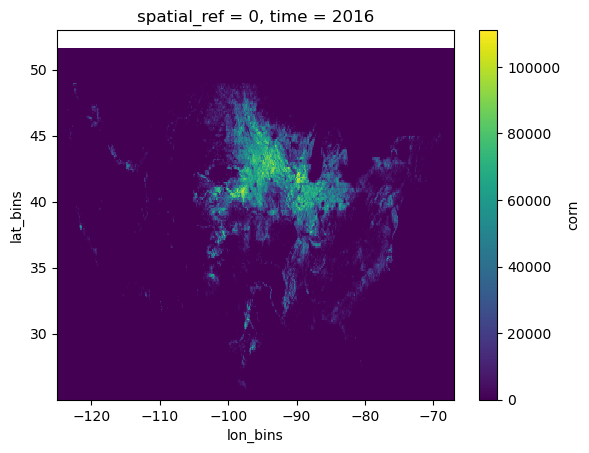

In [36]:
CDL_agg.corn.plot()

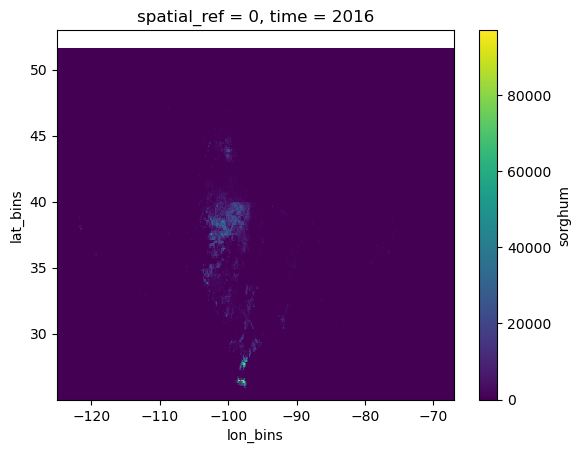

In [42]:
CDL_agg.sorghum.plot()